In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')

## Exploratory Data Analysis (EDA)
##### Columns
- id : a unique identifier for each tweet
- text : the text of the tweet
- location : the location the tweet was sent from (may be blank)
- keyword : a particular keyword from the tweet (may be blank)
- target : in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [3]:
print('Training data shape (rows, cols): ', df_train.shape)
df_train.head()

Training data shape (rows, cols):  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# keyword and location columns have some nulls
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
print('Test data shape (rows, cols): ', df_test.shape)
df_test.head()

Test data shape (rows, cols):  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# keyword and location columns have some nulls
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
# Null check
df_train['keyword'].isnull().value_counts() / df_train.shape[0]

False    0.991987
True     0.008013
Name: keyword, dtype: float64

In [8]:
df_train['location'].isnull().value_counts() / df_train.shape[0]

False    0.66728
True     0.33272
Name: location, dtype: float64

In [9]:
df_train['text'].isnull().value_counts() / df_train.shape[0]

False    1.0
Name: text, dtype: float64

In [10]:
df_test['keyword'].isnull().value_counts() / df_test.shape[0]

False    0.992032
True     0.007968
Name: keyword, dtype: float64

In [11]:
df_test['location'].isnull().value_counts() / df_test.shape[0]

False    0.661355
True     0.338645
Name: location, dtype: float64

In [12]:
df_test['text'].isnull().value_counts() / df_test.shape[0]

False    1.0
Name: text, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

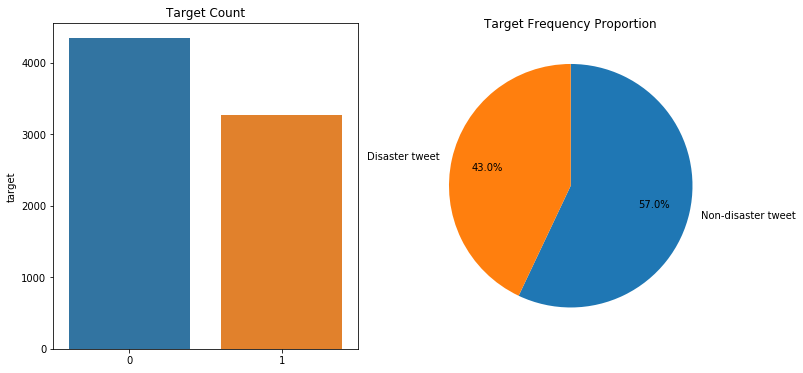

In [13]:
# Target Distribution (0 or 1)
dist_class = df_train['target'].value_counts()
labels = ['Non-disaster tweet', 'Disaster tweet']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

sns.barplot(x=dist_class.index, y=dist_class, ax=ax1).set_title("Target Count")

ax2.pie(dist_class,
        labels=labels,
        counterclock=False,
        startangle=90,
        autopct='%1.1f%%',
        pctdistance=0.7)
plt.title("Target Frequency Proportion")
plt.show

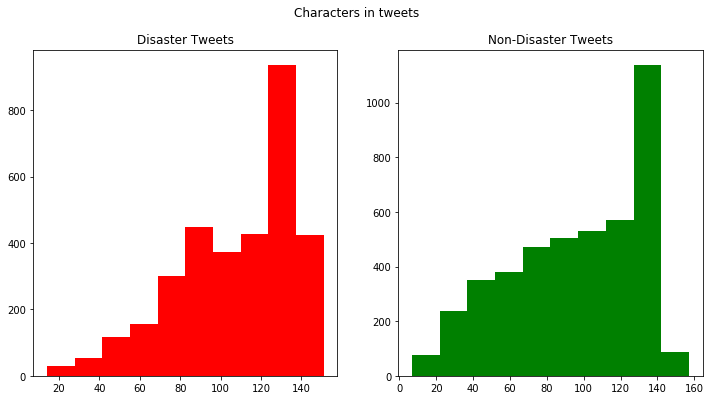

In [14]:
disaster_tweet_length = df_train[df_train['target']==1]['text'].str.len()
nondisaster_tweet_length = df_train[df_train['target']==0]['text'].str.len()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(disaster_tweet_length, color='red')
ax1.set_title("Disaster Tweets")

ax2.hist(nondisaster_tweet_length, color='green')
ax2.set_title("Non-Disaster Tweets")

fig.suptitle("Characters in tweets")
plt.show()

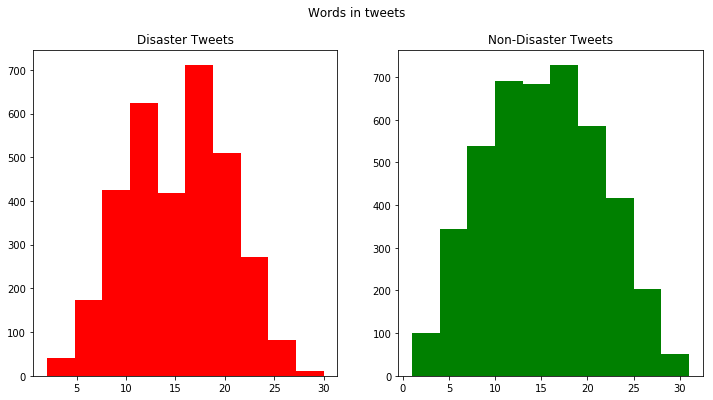

In [15]:
disaster_tweet_words = df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
nondisaster_tweet_words = df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(disaster_tweet_words, color='red')
ax1.set_title("Disaster Tweets")

ax2.hist(nondisaster_tweet_words, color='green')
ax2.set_title("Non-Disaster Tweets")

fig.suptitle("Words in tweets")
plt.show()

In [16]:
df_train_keyword = pd.DataFrame({
    'keyword': df_train['keyword'].value_counts().index,
    'count': df_train['keyword'].value_counts().values
})

df_train_location = pd.DataFrame({
    'location': df_train['location'].value_counts().index,
    'count': df_train['location'].value_counts().values
})

print('Number fo unique keywords in training data: ', df_train_keyword.shape[0])

px.bar(
    df_train_keyword,
    x='keyword',
    y='count',
    title="Each unique keyword count in training data"
).show()

px.bar(
    df_train_location,
    x=df_train_location['location'][:20],
    y=df_train_location['count'][:20],
    title="Top 20 location countin training data"
).show()

Number fo unique keywords in training data:  221


In [17]:
df_train[df_train['target'] == 1]['keyword'].value_counts()

outbreak       39
derailment     39
wreckage       39
debris         37
typhoon        37
               ..
ruin            1
body%20bag      1
blazing         1
electrocute     1
epicentre       1
Name: keyword, Length: 220, dtype: int64

In [18]:
df_train[df_train['target'] == 0]['keyword'].value_counts()

body%20bags          40
armageddon           37
harm                 37
wrecked              36
ruin                 36
                     ..
suicide%20bomber      1
oil%20spill           1
typhoon               1
suicide%20bombing     1
outbreak              1
Name: keyword, Length: 218, dtype: int64

In [19]:
df_train[df_train['target'] == 1]['location'].value_counts()

USA                67
United States      27
Nigeria            22
India              20
Mumbai             19
                   ..
Kansas City, MO     1
Georgia, U.S.A.     1
Charlotte, N.C.     1
Alberta             1
Dublin, Ireland     1
Name: location, Length: 1513, dtype: int64

In [20]:
df_train[df_train['target'] == 0]['location'].value_counts()

New York            55
USA                 37
London              29
United States       23
Los Angeles, CA     18
                    ..
Niall's arms         1
Hamburg, DE          1
canberra             1
Abuja, Nigeria       1
In the clouds...     1
Name: location, Length: 2142, dtype: int64

In [21]:
df_test_keyword = pd.DataFrame({
    'keyword': df_test['keyword'].value_counts().index,
    'count': df_test['keyword'].value_counts().values
})

df_test_location = pd.DataFrame({
    'location': df_test['location'].value_counts().index,
    'count': df_test['location'].value_counts().values
})

print('Number fo unique keywords in test data: ', df_test_keyword.shape[0])

px.bar(
    df_test_keyword,
    x='keyword',
    y='count',
    title="Each unique keyword count in test data"
).show()

px.bar(
    df_test_location,
    x=df_test_location['location'][:20],
    y=df_test_location['count'][:20],
    title="Top 20 location count in test data"
).show()

Number fo unique keywords in test data:  221


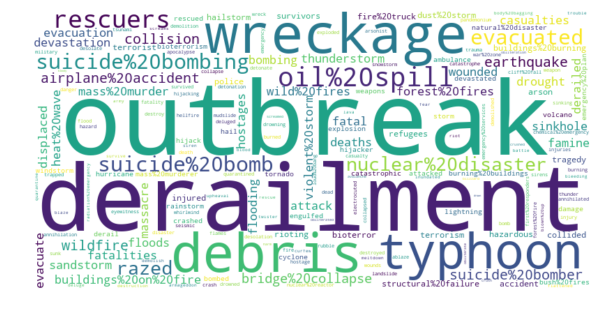

In [22]:
disaster_tweet = dict(df_train[df_train['target']==1]['keyword'].value_counts())

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(disaster_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

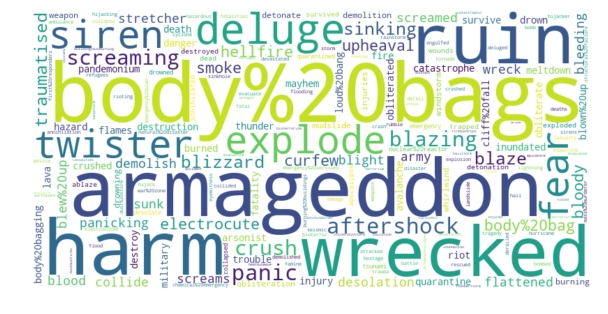

In [23]:
nondisaster_tweet = dict(df_train[df_train['target']==0]['keyword'].value_counts())

wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(nondisaster_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

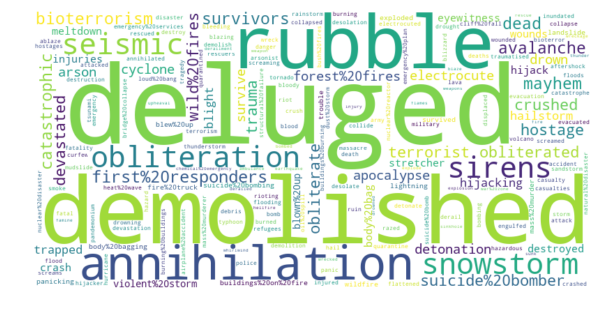

In [24]:
test_tweet = dict(df_test['keyword'].value_counts())

wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white").generate_from_frequencies(test_tweet)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Engineering (Data Cleaning? Data Pre-Processing?)

In [25]:
# https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

import string
def remove_punc(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

In [26]:
# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}

def unslang(text):
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text

In [27]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

def stemming(text):
    text = [stemmer.stem(word) for word in text]
    return text

In [28]:
for datas in [df_train, df_test]:
    datas['cleaned_text'] = datas['text'].apply(lambda x : remove_url(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : remove_html(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : remove_emoji(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : unslang(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : remove_punc(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : tokenization(x.lower()))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : remove_stopwords(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : stemming(x))
    datas['cleaned_text'] = datas['cleaned_text'].apply(lambda x : ' '.join(x))

In [29]:
df_train.head(10)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order califor...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfir updat california hwi 20 close direct ...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disast heavi rain caus flash flood stree...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,im top hill see fire wood
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,there emerg evacu happen build across street
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,im afraid tornado come area


In [30]:
df_train['text'][100]

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad'

In [31]:
df_train['cleaned_text'][100]

'norwaymfa bahrain polic previous die road accid kill explos '

In [32]:
df_test.head(10)

,id,keyword,location,text,cleaned_text
0,0,NaN,NaN,Just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond gees flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake,shakingit earthquak
6,21,NaN,NaN,They'd probably still show more life than Arse...,theyd probabl still show life arsen yesterday ...
7,22,NaN,NaN,Hey! How are you?,hey
8,27,NaN,NaN,What a nice hat?,nice hat
9,29,NaN,NaN,Fuck off!,fuck


In [33]:
df_test['text'][100]

'BROOO HE JUST GOT ANNIHILATED https://t.co/UR7QkqG1wf'

In [34]:
df_test['cleaned_text'][100]

'brooo got annihil '

## Modeling and Evaluation

In [35]:
vectorizer = CountVectorizer(analyzer='word', binary=True)
vectorizer.fit(df_train['cleaned_text'])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [36]:
# df_train_feature = df_train[['keyword', 'location', 'cleaned_text']]
# X = vectorizer.transform(df_train_feature).todense()
X = vectorizer.transform(df_train['cleaned_text']).todense()
y = df_train['target'].values

In [37]:
print(X.shape)
print(y.shape)

(7613, 14633)
(7613,)


In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
# from sklearn.model_selection import GridSearchCV

# params = {
#     'max_depth': list(range(5, 11)),
#     'learning_rate': list(np.arange(0.05, 0.30, 0.05)),
#     'gamma': list(np.arange(0.01, 0.06, 0.01)),
#     'min_child_weight': list(range(1, 6)),
    
#     # fixed params
#     'n_estimators' : [1500],
#     'n_jobs': [4],
#     'objective': ['binary:logistic'],
#     'eval_metric' : ['logloss'],
#     'random_state': [42]
# }

# model = XGBClassifier(tree_method='gpu_hist')
# cv = GridSearchCV(model, params, cv=5, n_jobs=4, scoring='roc_auc')

# cv.fit(X_train, y_train)

About how to tune the hyperparameters of XGBClassifier, I used ['Complete Guide to Parameter Tuning in XGBoost with codes in Python'](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) as reference.  
Actually I'd like to use GridSearchCV, however I gave up using it due to kernel memory issues.

In [40]:
xgb_classifir = XGBClassifier(tree_method='gpu_hist',
                              learning_rate=0.1,
                              num_round=1000,
                              max_depth=10,
                              min_child_weight=2,
                              colsample_bytree=0.8,
                              subsample=0.9,
                              gamma=0.4,
                              reg_alpha=1e-5,
                              reg_lambda=1,
                              n_estimators=2000,
                              objective='binary:logistic',
                              eval_metric=["auc", "logloss", "error"],
                              early_stopping_rounds=50)

# https://www.coursera.org/learn/competitive-data-science/lecture/wzi5a/hyperparameter-tuning-ii

In [41]:
%%time
xgb_classifir.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)])

[0]	validation_0-auc:0.621597	validation_0-logloss:0.680453	validation_0-error:0.335898	validation_1-auc:0.613672	validation_1-logloss:0.681005	validation_1-error:0.33275
[1]	validation_0-auc:0.636421	validation_0-logloss:0.669124	validation_0-error:0.322012	validation_1-auc:0.627631	validation_1-logloss:0.670357	validation_1-error:0.32049
[2]	validation_0-auc:0.660788	validation_0-logloss:0.658941	validation_0-error:0.312817	validation_1-auc:0.660313	validation_1-logloss:0.660548	validation_1-error:0.309107
[3]	validation_0-auc:0.673777	validation_0-logloss:0.650472	validation_0-error:0.312817	validation_1-auc:0.669156	validation_1-logloss:0.653022	validation_1-error:0.31042
[4]	validation_0-auc:0.692193	validation_0-logloss:0.642856	validation_0-error:0.319009	validation_1-auc:0.685104	validation_1-logloss:0.645779	validation_1-error:0.320053
[5]	validation_0-auc:0.69234	validation_0-logloss:0.636155	validation_0-error:0.303997	validation_1-auc:0.684797	validation_1-logloss:0.639348	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=50, eval_metric=['auc', 'logloss', 'error'],
              gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
              nthread=None, num_round=1000, objective='binary:logistic',
              random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
              verbosity=1)

In [42]:
y_pred_xgb = xgb_classifir.predict(X_valid)

In [43]:
print(y_pred_xgb)

[0 0 1 ... 0 1 1]


In [44]:
confusion_matrix(y_valid, y_pred_xgb)

array([[1133,  205],
       [ 269,  677]])

In [45]:
accuracy_score(y_valid, y_pred_xgb)

0.7924693520140105

In [46]:
f1_score(y_valid, y_pred_xgb)

0.7407002188183808

In [47]:
fpr, tpr, _ = roc_curve(y_valid, y_pred_xgb)
auc_score = auc(fpr, tpr)

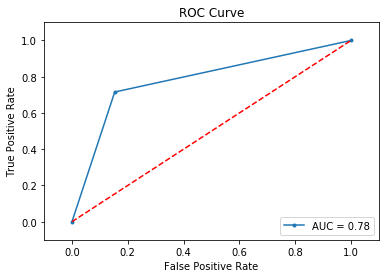

In [48]:
# clear current figure
plt.clf()

plt.title('ROC Curve')
plt.plot(fpr, tpr, marker='.', label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [49]:
predictions = [round(value) for value in y_pred_xgb]

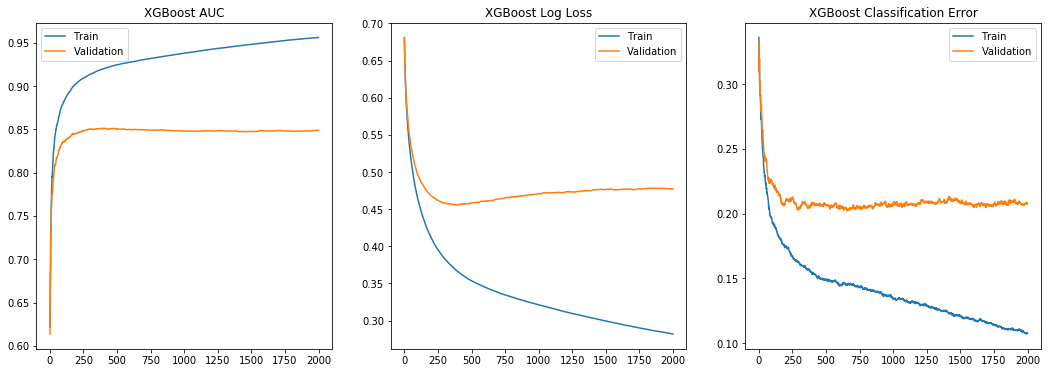

In [50]:
# retrieve performance metrics
results = xgb_classifir.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

# plot auc
ax1.plot(x_axis, results['validation_0']['auc'], label='Train')
ax1.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax1.set_title("XGBoost AUC")
ax1.legend()

# plot log loss
ax2.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax2.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax2.set_title("XGBoost Log Loss")
ax2.legend()

# plot classification error
ax3.plot(x_axis, results['validation_0']['error'], label='Train')
ax3.plot(x_axis, results['validation_1']['error'], label='Validation')
ax3.set_title("XGBoost Classification Error")
ax3.legend()

In [51]:
X_testset = vectorizer.transform(df_test['cleaned_text']).todense()

In [52]:
print(X_testset.shape)

(3263, 14633)


In [53]:
y_test_pred = xgb_classifir.predict(X_testset)

In [54]:
print(y_test_pred)

[1 1 1 ... 1 1 0]


## Submission

In [55]:
submission_file = pd.DataFrame({'id': df_test['id'], 'target': y_test_pred})
submission_file

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [56]:
submission_file.to_csv('submission_xgb_20200128.csv', index = False)